# Backpropagation

We will implement forward and backward propagation (backpropagation) for a fully connected neural network from scratch using numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data

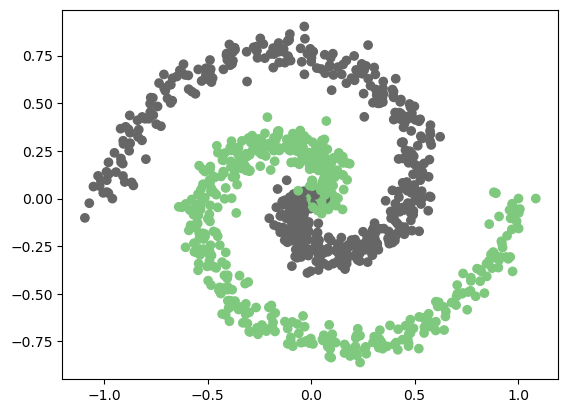

In [2]:
def get_spiral_data(offset = 0, std = 0.05, n_samples = 100):
    X = []
    for theta in np.linspace(0.1, 2 * np.pi, n_samples):
        r = theta / (2 * np.pi)
        x0 = r * np.cos(theta + offset) + std * np.random.randn()
        x1 = r * np.sin(theta + offset) + std * np.random.randn()
        X.append([x0, x1])
    return np.array(X)

def viz(X, Y):
    plt.scatter(X[:, 0], X[:, 1], c = Y, cmap="Accent")

n_samples = 1000
n_test = int(0.1 * n_samples)
X0 = get_spiral_data(n_samples = n_samples // 2)
X1 = get_spiral_data(offset = np.pi, n_samples = n_samples // 2)

ids = np.arange(n_samples)
np.random.shuffle(ids)
X = np.concatenate((X0, X1), axis = 0)[ids]
Y = np.concatenate((np.zeros((n_samples//2,1)), np.ones((n_samples//2,1))), axis = 0)[ids]
viz(X, Y)

Xtrain, Ytrain = X[:-n_test], Y[:-n_test]
Xtest, Ytest = X[-n_test:], Y[-n_test:]

# Forward pass

50.58373032284108


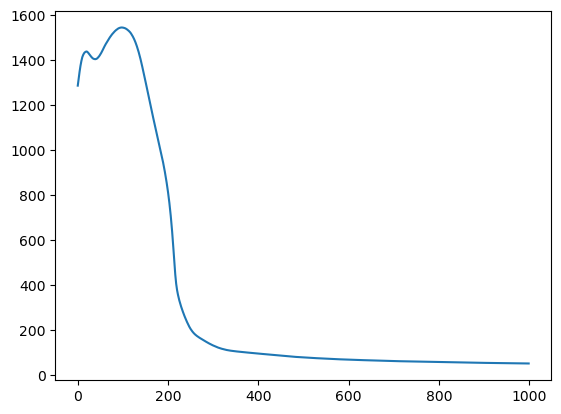

In [3]:
def relu(x):
    return np.maximum(x, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def transpose(x):
    # x: (n_batch, d0, d1)
    # Returns: (n_batch, d1, d0)
    return np.transpose(x, [0, 2, 1])

class FCN:
    # 4 layer network for binary classification: input + 2 hidden + output
    # Hidden activation is ReLU
    def __init__(self, din, d1, d2):
        self.din = din
        self.d1 = d1
        self.d2 = d2

        # random gaussian instead of xavier
        self.w1 = np.random.randn(din, d1)
        self.b1 = np.zeros((d1,1))

        self.w2 = np.random.randn(d1, d2)
        self.b2 = np.zeros((d2, 1))

        self.w3 = np.random.randn(d2, 1)
        self.b3 = np.zeros((1,1))

    def forward(self, X):
        yhat1 = X @ self.w1 + self.b1.T
        zhat1 = relu(yhat1)
        
        yhat2 = zhat1 @ self.w2 + self.b2.T
        zhat2 = relu(yhat2)

        yhat3 = zhat2 @ self.w3 + self.b3.T
        zhat3 = sigmoid(yhat3)

        self.X = X
        self.zhat1 = zhat1
        self.yhat2 = yhat2
        self.zhat2 = zhat2
        self.zhat3 = zhat3
        return zhat3

    def backward(self, grad_loss):
        # grad_loss: (n_batch, 1)
        
        din, d1, d2 = self.din, self.d1, self.d2

        X = self.X.reshape(-1, din, 1)
        w1 = self.w1.reshape(1, din, d1)
        w2 = self.w2.reshape(1, d1, d2)
        w3 = self.w3.reshape(1, d2, 1)
        zhat1 = self.zhat1.reshape(-1, d1, 1)
        yhat2 = self.yhat2.reshape(-1, d2, 1)
        zhat2 = self.zhat2.reshape(-1, d2, 1)
        zhat3 = self.zhat3.reshape(-1, 1, 1)
        
        
        # (n_batch, 1, 1)
        grad_zhat3 = grad_loss.reshape(-1, 1, 1)
        grad_yhat3 = grad_zhat3 * zhat3 * (1 - zhat3)

        ## One layer ##
        # (d2, 1)
        grad_w3 = yhat2 @ grad_yhat3 # (n_batch, 1, 1) X (n_batch, 1, d2)
        self.grad_w3 = np.sum(grad_w3, axis = 0)
        # (1, 1)
        self.grad_b3 = np.sum(grad_yhat3, axis = 0)
        # (n_batch, 1, d2)
        grad_zhat2 = grad_yhat3 @ transpose(w3)
        # (n_batch, 1, d2)
        grad_yhat2 = (transpose(zhat2) > 0) * grad_zhat2

        ## One layer ##
        # (d1, d2)
        grad_w2 = zhat1 @ grad_yhat2 # (n_batch, d1, 1) X (n_batch, 1, d2)  
        self.grad_w2 = np.sum(grad_w2, axis = 0)
        # (1, d2)
        self.grad_b2 = np.sum(grad_yhat2, axis=0)
        # (n_batch, 1, d1)
        grad_zhat1 = grad_yhat2 @ transpose(w2) # (n_batch, 1, d2) X (1, d2, d1)
        # (n_batch, 1, d1)
        grad_yhat1 = (transpose(zhat1) > 0) * grad_zhat1

        ## One layer ##
        # (din, d1)
        grad_w1 = X @ grad_yhat1 # (n_batch, din, 1) X (n_batch, 1, d1)
        self.grad_w1 = np.sum(grad_w1, axis = 0)
        # (1, d1)
        self.grad_b1 = np.sum(grad_yhat1, axis = 0)
        # (n_batch, 1, din) (Not used, but presented for the sake of completeness)
        grad_x = grad_yhat1 @ transpose(w1) # (n_batch, 1, d1) X (1, d1, din)

class BCE:
    # Binary Cross Entropy Loss
    def __init__(self):
        pass

    def forward(self, ypred, ytarg):
        """
        Classes are 0 and 1
        ypred: (n_batch, 1): Prob of class 1
        ytarg: (n_batch, 1)
        """
        self.ytarg = ytarg
        loss = - (ytarg * np.log(ypred) + (1 - ytarg) * np.log(1 - ypred))
        return loss.sum()

    def backward(self):
        """
        must be called after forward
        """
        return 1 - 2 * self.ytarg

fcn = FCN(2, 20, 10)
bce = BCE()

epochs = 1000
lr = 3e-4
loss_list = []
for e in range(epochs):
    Ypred = fcn.forward(Xtrain)
    loss = bce.forward(Ypred, Ytrain)

    grad_loss = bce.backward()
    fcn.backward(grad_loss)

    fcn.w3 -= lr * fcn.grad_w3
    fcn.b3 -= lr * fcn.grad_b3.T

    fcn.w2 -= lr * fcn.grad_w2
    fcn.b2 -= lr * fcn.grad_b2.T

    fcn.w1 -= lr * fcn.grad_w1
    fcn.b1 -= lr * fcn.grad_b1.T
    loss_list.append(loss)

plt.plot(loss_list)
print(loss_list[-1])    

# Eval

Accuracy: 0.97


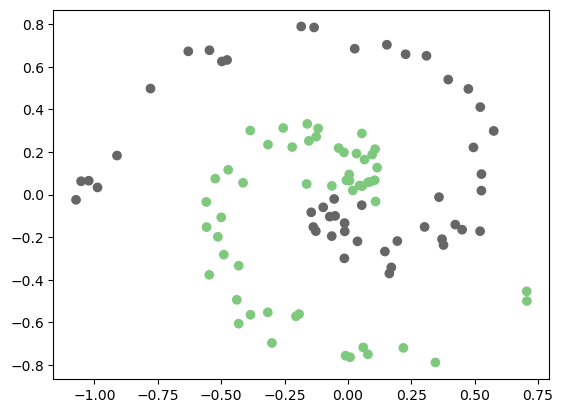

In [4]:
Ypred = fcn.forward(Xtest)
Ypred_class = Ypred > 0.5
correct = (Ypred_class == Ytest).astype(int)
accuracy = np.mean(correct)
print(f"Accuracy: {accuracy}")
viz(Xtest, Ypred_class)